In [2]:
import IPython, graphviz, re
#import pydotplus
from io import StringIO
from IPython.display import Image  
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.datasets import load_boston, load_iris
from collections import defaultdict

## Data Load

In [3]:
# decision tree on diabetes data

clf = tree.DecisionTreeRegressor(max_depth=3)
boston = load_boston()

In [4]:
# decision tree on diabetes data

# clf = tree.DecisionTreeClassifier()
# iris = load_iris()

In [5]:
# iris.data.shape, iris.target.shape

In [6]:
boston.data.shape, boston.target.shape

((506, 13), (506,))

In [7]:
data = pd.DataFrame(boston.data)

In [8]:
data.columns =boston.feature_names

In [9]:
clf = clf.fit(data, boston.target)

## Functions

In [10]:
def tree_traverse(n_nodes, children_left, children_right):
    """
    Traversing tree structure to compute compute various properties such
    as the depth of each node and whether or not it is a leaf.
    
    Input -
    n_nodes: number of nodes in the tree
    children_left: array of length n_nodes. left children node indexes
    children_right: array of length n_nodes. right children node indexes
    
    Output - 
    is_leaves: array of length n_nodes with boolean whether node i is leaf or not
    
    """
    
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    
    while len(stack) > 0:
        node_id, parent_depth = stack.pop() # (0,-1)
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True
    
    return is_leaves

In [11]:
def print_all_targs(list_tar, max_one_line=5):
    """
    Format to print sample targets. Maximum numbers in a line    
    """
    st=''
    if len(list_tar)<=max_one_line:
        st+= ', '.join(map(str,list_tar))
    else:     
        for i in range(len(list_tar)//max_one_line+1):
            st+= ', '.join(map(str, list_tar[i*max_one_line:(i+1)*max_one_line])) + "\n"   
    return st

In [12]:
def abbr_target(list_tar, max_len=10, max_one_line=5):
    """
    Abbreviate list if length > max_len
    
    Input - 
    list_tar: input list to print
    max_one_line: maximum numbers to print in one line
    max_len: maximum lenght to print samples
    
    Output -
    disp_str: string to display list of numbers in format of 123 ... 456 with linebreaks based on max_one_line
    """    
    
    if len(list_tar) > max_len:        
        # disp only first 5 and last 5 if len>10
        disp_str = print_all_targs(list_tar[:max_len//2], max_one_line) + "\n"+ " ... " + \
                   print_all_targs(list_tar[-max_len//2:], max_one_line)
    else: 
        disp_str = print_all_targs(list_tar, max_one_line)
    
    return disp_str

In [13]:
def get_samples(clf, data):
    """
    Sample indexes falling in each node
    """

    samples = defaultdict(list)
    dec_paths = clf.decision_path(data)

    for d, dec in enumerate(dec_paths):
        for i in range(clf.tree_.node_count):
            if dec.toarray()[0][i]  == 1:
                samples[i].append(d) 
    return samples

In [14]:
YELLOW = "#fefecd" # "#fbfbd0" # "#FBFEB0"

def feature_html(data, test_id, bgcolor=YELLOW):
    """
    HTML table for feature vector
    """
    header = '<table BORDER="0" CELLBORDER="0" CELLSPACING="0">\n'
    tail = "</table>\n"

    N = len(data.columns)
    value_html = '<td port="%s" bgcolor="%s" border="1" width="30px" align="center"><font point-size="9">%s</font></td>\n'

    titlerow = '<tr><td cellspacing="0" colspan="%d" cellpadding="0" border="1" sides="b" align="center"><font color="#444443" FACE="Times-Italic" point-size="11">%s</font></td></tr>\n' % (N, "Feature variables of test data")
    toprow = [value_html % (i,bgcolor,list(data.columns)[i]) for i in range(N)]
    bottomrow = [value_html % (i,bgcolor,list(data.iloc[test_id])[i]) \
                 for i in range(N)]
    
    return header + titlerow + '<tr>\n'+''.join(toprow)+'</tr>\n' + '<tr>\n'+''.join(bottomrow)+'</tr>' + tail

In [15]:
clf.tree_.children_left

array([ 1,  2,  3, -1, -1,  6, -1, -1,  9, 10, -1, -1, 13, -1, -1])

In [16]:
clf.tree_.children_right

array([ 8,  5,  4, -1, -1,  7, -1, -1, 12, 11, -1, -1, 14, -1, -1])

In [17]:
def node_string(clf,
                datax,
                datay,
                test_id = None,
                show_pred_only=False,
                show_mse_leafcount=True,
                showsamples=False,
                orientation="LR",
                precision=1,
                nonleaf_results = False,
                max_len_targs=8,
                max_one_line=5,
                show_test_feat=False):
    """
    String to use as input for graphviz

    Input -
    clf: sklearn decision tree model
    data: input training data (without target variable)
    verbose: if Ture, prints the predictions, number of samples and impurity for non-leaf nodes also
    classifier: True if classification problem, False if regression problem
    precision: rounding off precision required to print the predictions, values or impurity


    Output -
    st: string that can be used as input for displaying decision tree using graphviz

    """
    # parsing the tree structure
    n_nodes = clf.tree_.node_count  # total nodes in the tree
    children_left = clf.tree_.children_left  # left children node index
    children_right = clf.tree_.children_right  # right children node index
    feature = clf.tree_.feature  # feature index at splits (-2 means leaf)
    threshold = clf.tree_.threshold  # split threshold values at given feature
    
    is_leaves = tree_traverse(n_nodes, children_left, children_right)
    
    sample_print_init = n_nodes # inititate new node at the end with max available index
    
#     # classifier or regressor
#     if str(type(clf)) == "<class 'sklearn.tree.tree.DecisionTreeRegressor'>":
#         impurity = 'mse'       
        
#     else:
#         impurity = 'gini'
        
    
    ###############
    # fixed string setup
    st = '\ndigraph G {\n ranksep=equally;\n \
                        splines=line;\n \
                        nodesep=0.05;\n \
                        rankdir=%s;\n \
                        node [shape=plain width=0.5 height=0.5 fixedsize=False];\n \
                        edge [arrowsize=0.5]\n' % orientation

    # non leaf node feature names. if nonleaf_results=True, get prediction and other results also. 
    for i in range(n_nodes):
        if not is_leaves[i]:  # non leaf nodes
            st += str(i) + " [fontsize=10 label=\"%s \"]" % (str(datax.columns[feature[i]]))
            st += '\n '
            
    # get target values for leaf nodes. verbose conditions
    for i in range(n_nodes):        
        if is_leaves[i]:
            value = clf.tree_.value[i][0]
            node_samples = clf.tree_.n_node_samples
            impurity = clf.tree_.impurity
            
            if show_pred_only and not showsamples:  # only show prediction in leaf node
                st += str(i) + " [fontsize=10 fillcolor=yellow style=filled shape=box label=\"prediction=%s \"]" % \
                    (str(np.round(value[0], precision)))

            if show_mse_leafcount and not show_pred_only and not showsamples:  # show prediction, samples, mse in leaf node
                st += str(i) + " [fontsize=10 fillcolor=yellow style=filled shape=box label=\"prediction=%s \n n_samples=%s \n mse=%s \"]" % \
                    (str(np.round(value[0], precision)),
                     node_samples[i],
                     np.round(impurity[i], precision))

            if showsamples:  # show samples at each leaf node                    

                # addition nodes with samples
                # make dictionary with node number: observation index mapping
                samples= get_samples(clf, datax)
                samples_i = np.sort(datay[samples[i]])

                # display string
                disp = abbr_target(samples_i, max_len_targs, max_one_line)

                # everything that is there in verbose=1
                st += str(i) + " [fillcolor=yellow style=filled shape=box width=2 fontsize=9 label=\"prediction=%s \n n_samples=%s \n mse=%s \n targets=%s \"]" % \
                    (str(np.round(value[0], precision)),
                     node_samples[i],
                     np.round(impurity[i], precision),
                     disp )
    
    # non leaf edges with > and <=
    for i in range(n_nodes):
        if not is_leaves[i]:
            st += str(i) + "->" + str(children_left[i]) + " [fontsize=10 label=\"<%s\"]" % str(
                np.round(threshold[i], precision))
            st += str(i) + "->" + str(children_right[i]) + " [fontsize=10 label=\">=%s\"]" % str(
                np.round(threshold[i], precision))

    # getting prediction path for test id
    if test_id is not None:
        test_data = datax.iloc[test_id:test_id+1]
        node_indicator = clf.decision_path(test_data)
        node_indexes = node_indicator.indices
        
        for idx in range(len(node_indexes)-1):
            st += str(node_indexes[idx]) + "->" + str(node_indexes[idx]+1) + " [color=red]"        
        
        # html table for test sample
        if show_test_feat:
            htm = feature_html(datax, test_id)
            st += str(n_nodes+1) +  " [label=<%s>]" % htm
            st += "0->" + str(n_nodes+1) + " [color=white]"

    # end of string
    st = st+'}'

    return st

## Example cases

### `Default regression case without any test obervation`

In [18]:
st = node_string(clf, data, boston.target)

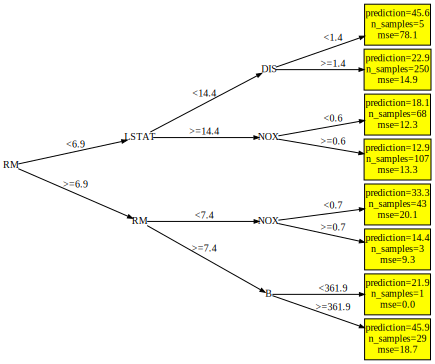

In [19]:
graphviz.Source(st)

### `show_pred_only=True`

In [20]:
st = node_string(clf, data, boston.target, show_pred_only=True)

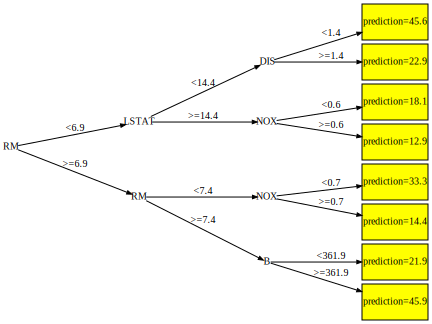

In [21]:
graphviz.Source(st)

### `showsamples=True`

In [22]:
st = node_string(clf, data, boston.target, showsamples=True)

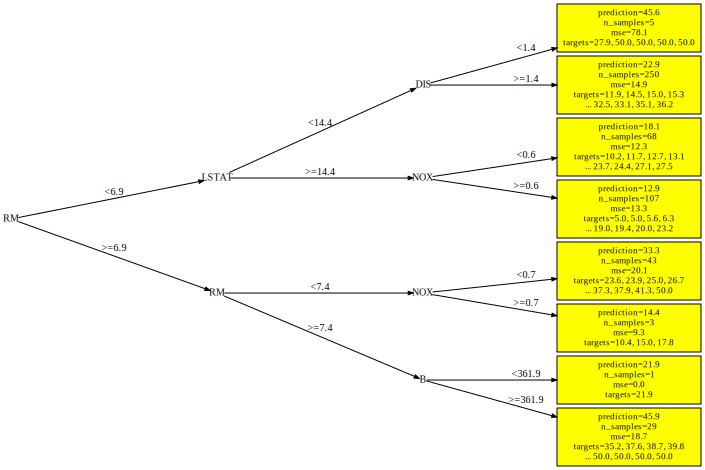

In [23]:
graphviz.Source(st)

### `showsamples=True with different max_one_line and max_len_targs`

In [24]:
st = node_string(clf, data, boston.target, showsamples=True, max_len_targs=14, max_one_line=4)

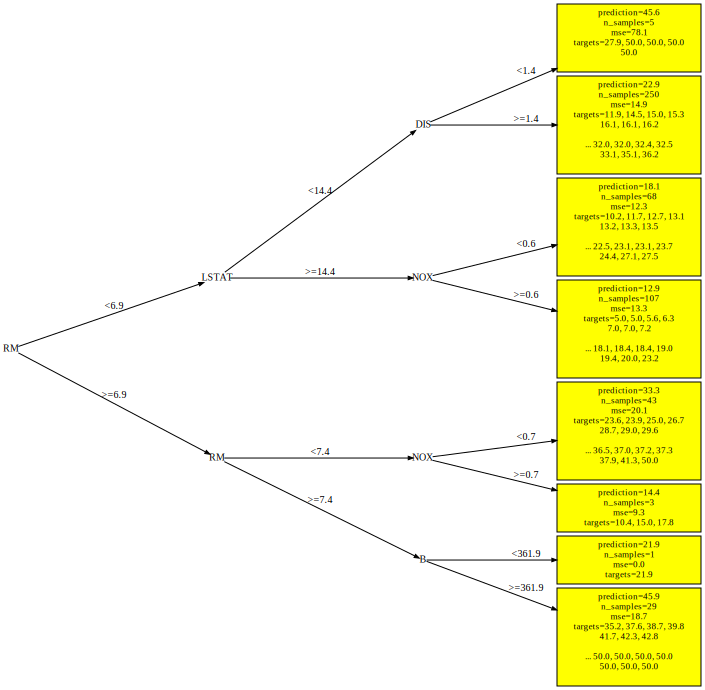

In [25]:
graphviz.Source(st)

### `path of test_sample with TD orientation`

In [26]:
st = node_string(clf, data,  boston.target, test_id=2,orientation="TD")

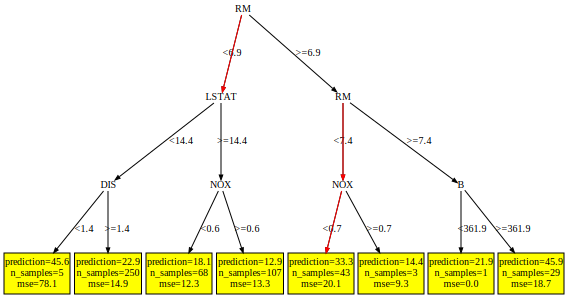

In [27]:
graphviz.Source(st)

### `show_test_feat=True` to show test feature vector as html table

In [28]:
st = node_string(clf, data,  boston.target, test_id=20,orientation="TD", show_test_feat=True)

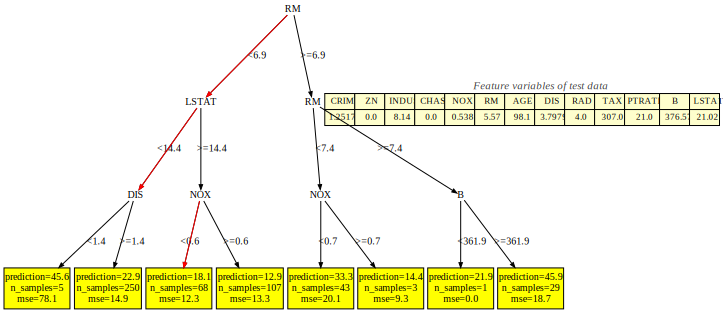

In [29]:
graphviz.Source(st)

### End